In [ ]:
# Basic Libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing
import scipy.sparse as sps
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

# Surprise (For RS1)
from surprise import (
    BaselineOnly,
    KNNBasic,
    KNNWithMeans,
    KNNBaseline,
    SVD,
    SVDpp,
    NMF,
    SlopeOne,
    CoClustering,
)
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader
import myfm

# LibRecommender (For RS2)
from libreco.data import random_split, DatasetFeat
from libreco.algorithms import NCF, WideDeep
from libreco.evaluation import evaluate
import random
import tensorflow as tf
import optuna

warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use("ggplot")
image_path = "images/"

# Data exploration


## New Movielens-100k


In [3]:
data_path = "ml-latest-small/"
df_rating = pd.read_csv(f"{data_path}ratings.csv")
df_rating

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
sparsity = 1 - len(df_rating) / (
    df_rating["movieId"].unique().shape[0] * df_rating["userId"].unique().shape[0]
)
print(f"sparsity: {sparsity:.4%}")
df_rating

sparsity: 98.3000%


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Distribution of Ratings


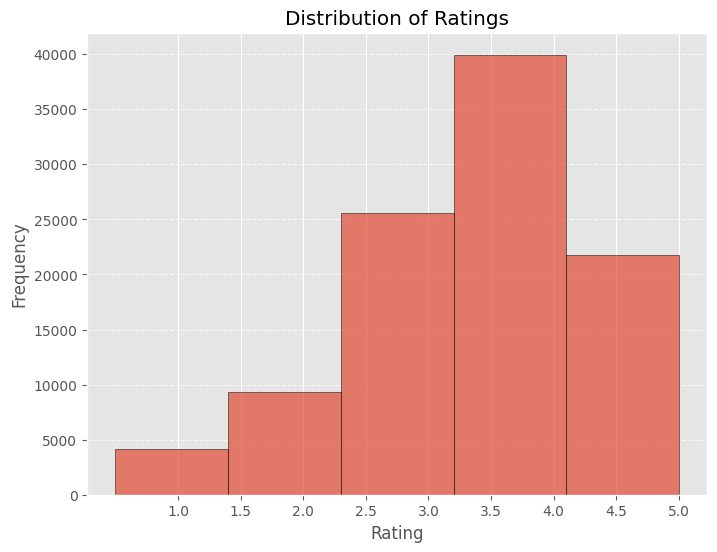

In [5]:
# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_rating["rating"], bins=5, edgecolor="black", alpha=0.7)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Distribution of Ratings per movie/user


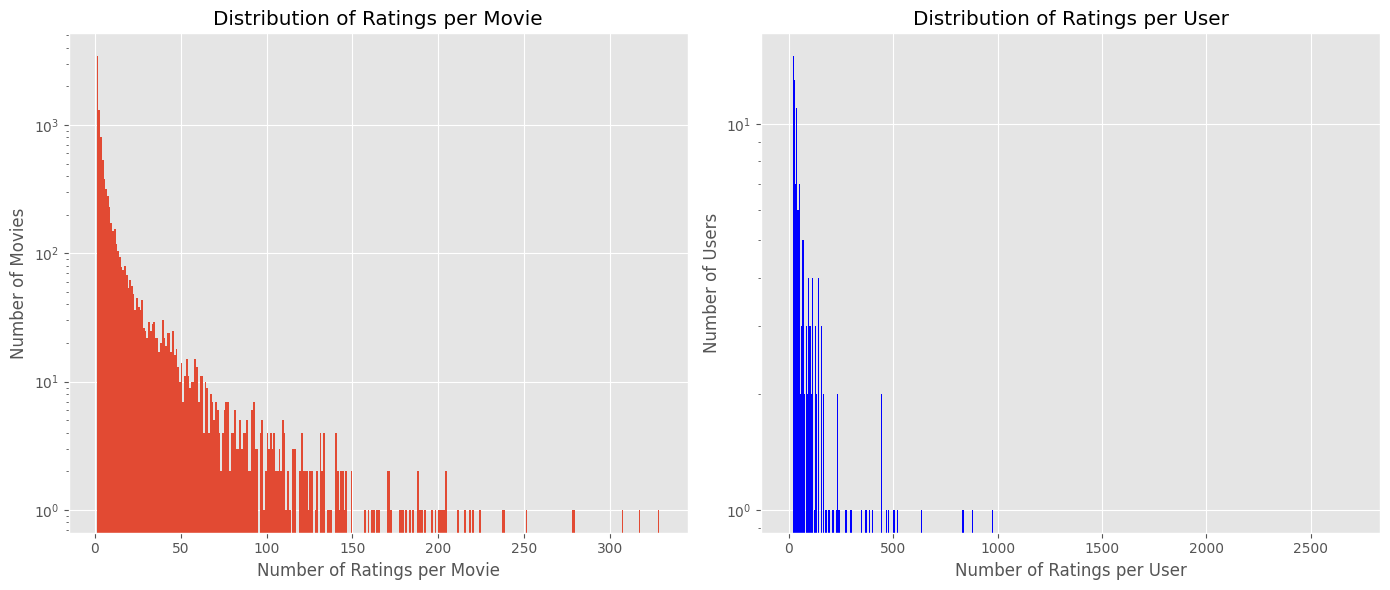

In [6]:
rating_count = df_rating["movieId"].value_counts()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(rating_count, bins=range(1, rating_count.max() + 1), log=True)
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movies")
plt.title("Distribution of Ratings per Movie")
plt.grid(True)

user_rating_count = df_rating["userId"].value_counts()
plt.subplot(1, 2, 2)
plt.hist(
    user_rating_count,
    bins=range(1, user_rating_count.max() + 1),
    log=True,
    color="blue",
)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Ratings per User")
plt.grid(True)
plt.tight_layout()
plt.show()

### Additional metadata


In [7]:
df_movie = pd.read_csv(f"{data_path}movies.csv")
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [8]:
df_movie["release_year"] = df_movie["title"].str.extract(r"\((\d{4})\)")
df_movie["title"] = df_movie["title"].str.replace(r"\s*\(\d{4}\)$", "", regex=True)
df_movie["release_year"] = df_movie["release_year"].astype(str)
print(df_movie["release_year"].isnull().sum())
df_movie

0


,movieId,title,genres,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018


In [9]:
df_tag = pd.read_csv(f"{data_path}tags.csv")
df_tag

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [10]:
df_link = pd.read_csv(f"{data_path}links.csv")
df_link

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


# Recommender System Model


## Pure Collaborative Filtering (No extra metadata)


In [21]:
# Load movielens-100k dataset
reader = Reader()
data = Dataset.load_from_df(df_rating[["userId", "movieId", "rating"]], reader)

# List of algorithms to test
algorithms = [
    BaselineOnly(),
    KNNBasic(),
    KNNWithMeans(),
    KNNBaseline(),
    SVD(),
    SVDpp(),
    NMF(),
    SlopeOne(),
    CoClustering(),
]

algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
]

# Dictionary to store results
results = {}

# Run cross-validation for each algorithm
for algo, name in zip(algorithms, algo_names):
    cv_results = cross_validate(
        algo, data, measures=["rmse", "mae"], cv=5, verbose=False
    )
    results[name] = {
        "RMSE": np.mean(cv_results["test_rmse"]),
        "MAE": np.mean(cv_results["test_mae"]),
    }

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating 

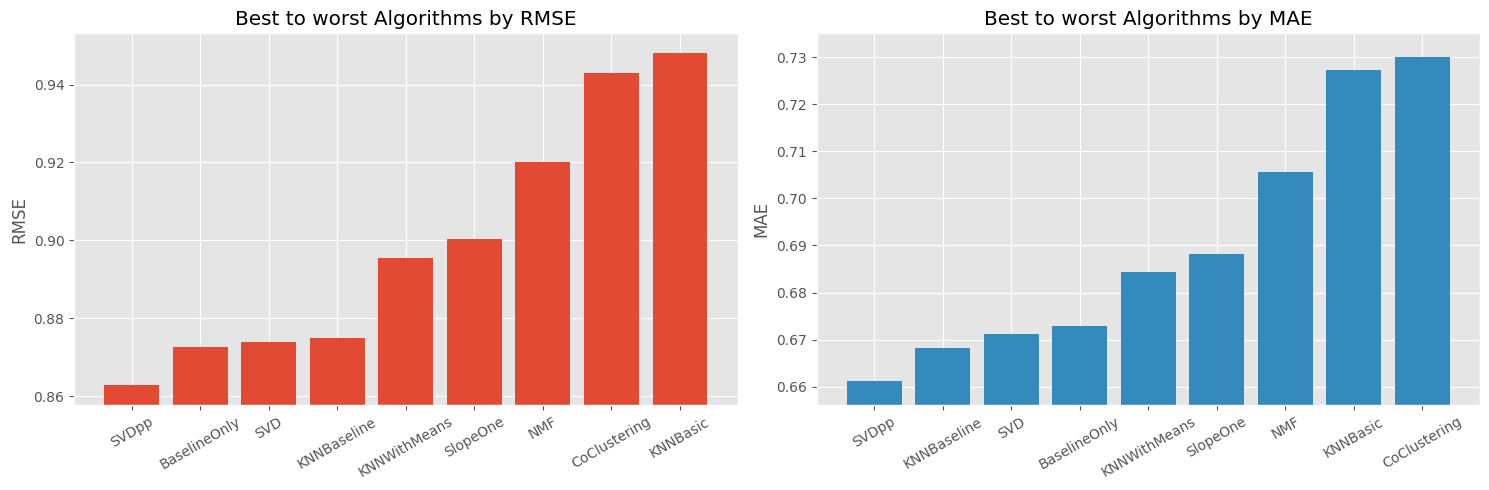

{'BaselineOnly': {'RMSE': 0.8724920183317781, 'MAE': 0.6728003991192218},
 'KNNBasic': {'RMSE': 0.9481740258445395, 'MAE': 0.7272079353654555},
 'KNNWithMeans': {'RMSE': 0.8955956496795819, 'MAE': 0.6844340646070446},
 'KNNBaseline': {'RMSE': 0.8748540091012403, 'MAE': 0.6683146170335565},
 'SVD': {'RMSE': 0.8737709758144181, 'MAE': 0.6711812673921982},
 'SVDpp': {'RMSE': 0.8627264328323765, 'MAE': 0.6611232242151358},
 'NMF': {'RMSE': 0.9200315476119151, 'MAE': 0.705533775296874},
 'SlopeOne': {'RMSE': 0.9003782381054389, 'MAE': 0.6882258082668695},
 'CoClustering': {'RMSE': 0.9430172286942792, 'MAE': 0.7300473908109396}}

In [22]:
algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)
# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst Algorithms by RMSE")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst Algorithms by MAE")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}surpise_algo_comparison.png", dpi=300)
plt.show()
results

In [ ]:
df_train, df_test = train_test_split(df_rating, test_size=0.2, random_state=42)


def get_extended_features(
    X_train_base,
    X_test_base,
    df_train,
    df_test,
    incluse_variance=False,
    include_release_year=False,
    include_genres=False,
):
    X_train_ext = X_train_base
    X_test_ext = X_test_base
    group_shapes = None

    if incluse_variance:
        group_shapes = [len(group) for group in ohe.categories_]

    if include_release_year:
        X_train_release = movie_info_ohe.transform(
            movie_info.reindex(df_train.movieId).drop(columns=["genres"])
        )
        X_test_release = movie_info_ohe.transform(
            movie_info.reindex(df_test.movieId).drop(columns=["genres"])
        )
        X_train_ext = sps.hstack([X_train_ext, X_train_release])
        X_test_ext = sps.hstack([X_test_ext, X_test_release])
        group_shapes.extend([len(group) for group in movie_info_ohe.categories_])

    if include_genres:
        X_train_genres = movie_genre_mle.transform(
            movie_info.genres.reindex(df_train.movieId).apply(lambda x: x.split("|"))
        )
        X_test_genres = movie_genre_mle.transform(
            movie_info.genres.reindex(df_test.movieId).apply(lambda x: x.split("|"))
        )
        X_train_ext = sps.hstack([X_train_ext, X_train_genres])
        X_test_ext = sps.hstack([X_test_ext, X_test_genres])
        group_shapes.append(len(movie_genre_mle.classes_))

    return X_train_ext, X_test_ext, group_shapes


def train_predict_fm(
    df,
    include_variance=False,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []
    mae_scores = []

    for train_index, test_index in kf.split(df):
        df_train, df_test = df.iloc[train_index], df.iloc[test_index]

        X_train_base = ohe.transform(df_train[FEATURE_COLUMNS])
        X_test_base = ohe.transform(df_test[FEATURE_COLUMNS])
        y_train = df_train.rating.values
        y_test = df_test.rating.values

        X_train_ext, X_test_ext, group_shapes = get_extended_features(
            X_train_base,
            X_test_base,
            df_train,
            df_test,
            incluse_variance=include_variance,
            include_release_year=include_release_year,
            include_genres=include_genres,
        )

        model = myfm.MyFMRegressor(rank=fm_rank, random_seed=42)
        model.fit(
            X_train_ext,
            y_train,
            n_iter=200,
            n_kept_samples=200,
            group_shapes=group_shapes,
        )
        prediction = model.predict(X_test_ext)
        rmse = np.sqrt(((y_test - prediction) ** 2).mean())
        mae = np.abs(y_test - prediction).mean()

        rmse_scores.append(rmse)
        mae_scores.append(mae)

    mean_rmse = np.mean(rmse_scores)
    mean_mae = np.mean(mae_scores)

    return mean_rmse, mean_mae


# Usage example
FEATURE_COLUMNS = ["userId", "movieId"]
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(df_rating[FEATURE_COLUMNS])

movie_info = df_movie.set_index("movieId")[["release_year", "genres"]]
movie_info_ohe = OneHotEncoder(handle_unknown="ignore").fit(
    movie_info[["release_year"]]
)
movie_genre_mle = MultiLabelBinarizer(sparse_output=True).fit(
    movie_info.genres.apply(lambda x: x.split("|"))
)

alpha = 1.83 w0 = 3.35 : 100%|██████████| 200/200 [00:04<00:00, 44.82it/s]


(0.8529920798054922, 0.6552049988447564)

In [13]:
results_with_metadata = {}

output = train_predict_fm(
    df=df_rating,
    include_variance=False,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["baseline"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance/releaseYear"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=False,
    include_genres=True,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance/genres"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=True,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["everything"] = {"RMSE": output[0], "MAE": output[1]}

results_with_metadata

alpha = 2.31 w0 = 3.54 : 100%|██████████| 200/200 [00:10<00:00, 18.53it/s]


{'baseline': {'RMSE': 0.8529920798054922, 'MAE': 0.6552049988447564},
 'variance': {'RMSE': 0.8337999971010254, 'MAE': 0.6373708455231607},
 'variance/releaseYear': {'RMSE': 0.8241096632459695,
  'MAE': 0.6300280432952035},
 'variance/genres': {'RMSE': 0.8160679000134117, 'MAE': 0.624166666029912},
 'everything': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903}}

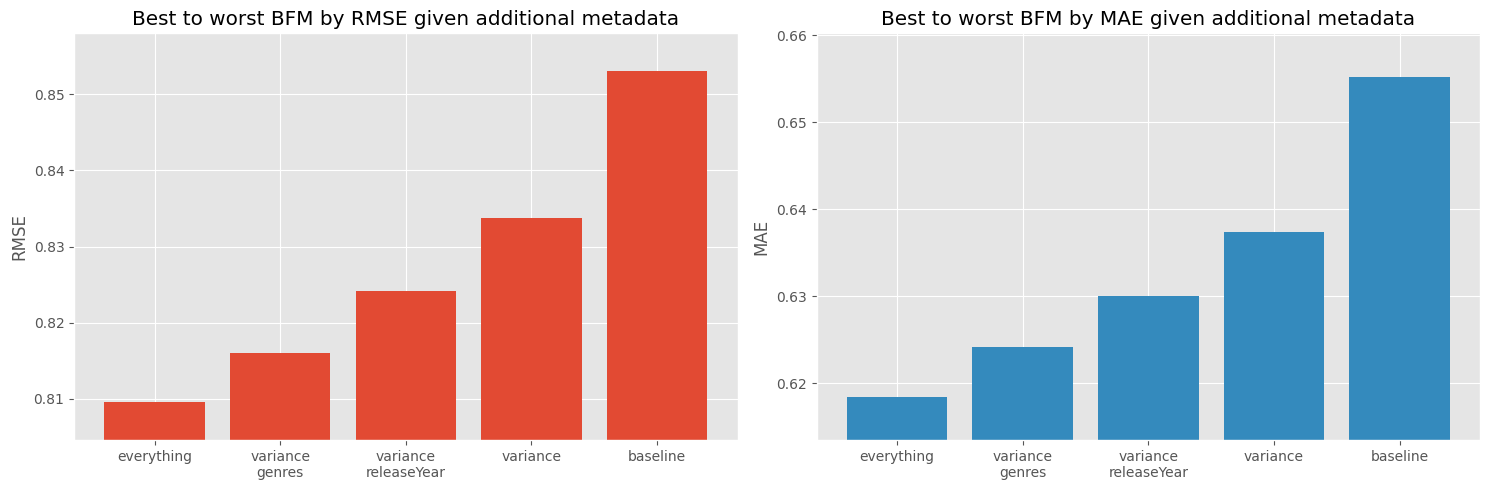

{'baseline': {'RMSE': 0.8529920798054922, 'MAE': 0.6552049988447564},
 'variance': {'RMSE': 0.8337999971010254, 'MAE': 0.6373708455231607},
 'variance/releaseYear': {'RMSE': 0.8241096632459695,
  'MAE': 0.6300280432952035},
 'variance/genres': {'RMSE': 0.8160679000134117, 'MAE': 0.624166666029912},
 'everything': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903}}

In [14]:
algo_names = [
    "baseline",
    "variance",
    "variance/releaseYear",
    "variance/genres",
    "everything",
]
rmse_scores = np.array([results_with_metadata[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results_with_metadata[name]["MAE"] for name in algo_names])

order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)

algo_names_rmse = [algo_names[i].replace("/", "\n") for i in order_rmse]
algo_names_mae = [algo_names[i].replace("/", "\n") for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst BFM by RMSE given additional metadata")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=0)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst BFM by MAE given additional metadata")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=0)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}bfm_metadata_comparison.png", dpi=300)
plt.show()
results_with_metadata

In [17]:
results_with_FM = {}

for fm_rank in [10, 15, 20, 25, 30, 35, 40]:
    output = train_predict_fm(
        df=df_rating,
        include_variance=True,
        include_release_year=True,
        include_genres=True,
        fm_rank=fm_rank,
        n_splits=5,
    )
    results_with_FM[f"{fm_rank}"] = {"RMSE": output[0], "MAE": output[1]}

results_with_FM

alpha = 3.15 w0 = 3.58 : 100%|██████████| 200/200 [00:40<00:00,  4.94it/s]


{'10': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903},
 '15': {'RMSE': 0.8078713046385703, 'MAE': 0.6171318072640773},
 '20': {'RMSE': 0.8067885988048065, 'MAE': 0.6163814903008937},
 '25': {'RMSE': 0.807556169205054, 'MAE': 0.6165670606260625},
 '30': {'RMSE': 0.8076044236135693, 'MAE': 0.6169995064451081},
 '35': {'RMSE': 0.8075236626964785, 'MAE': 0.6168251377452408},
 '40': {'RMSE': 0.8077819685049361, 'MAE': 0.6169657037629094}}

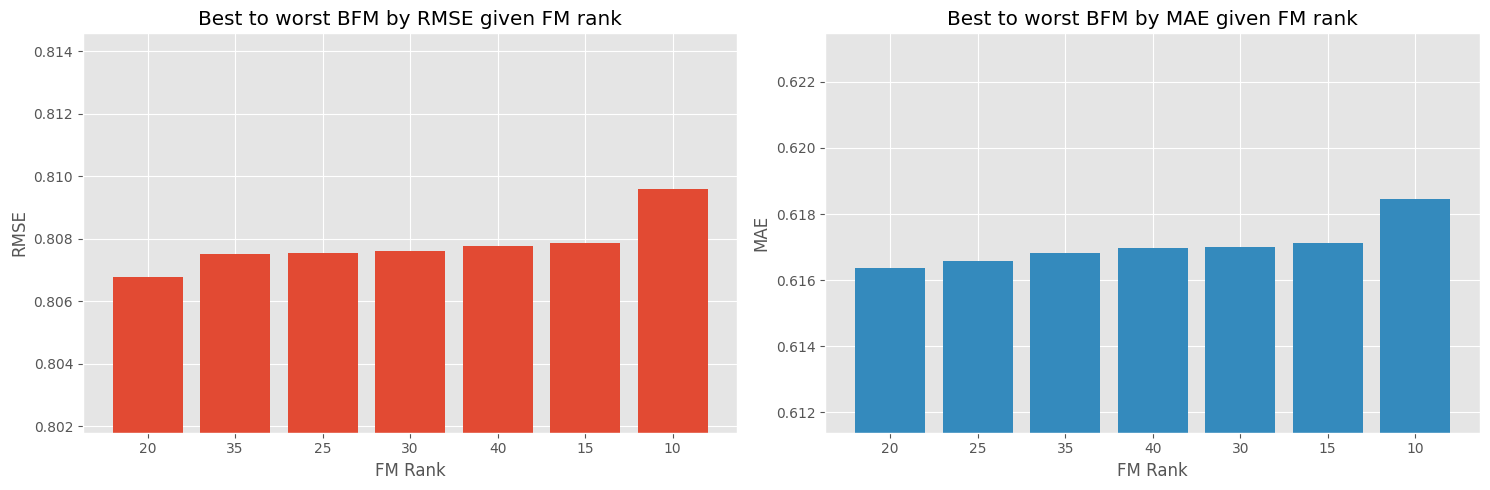

{'baseline': {'RMSE': 0.8529920798054922, 'MAE': 0.6552049988447564},
 'variance': {'RMSE': 0.8337999971010254, 'MAE': 0.6373708455231607},
 'variance/releaseYear': {'RMSE': 0.8241096632459695,
  'MAE': 0.6300280432952035},
 'variance/genres': {'RMSE': 0.8160679000134117, 'MAE': 0.624166666029912},
 'everything': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903}}

In [18]:
algo_names = ["10", "15", "20", "25", "30", "35", "40"]
rmse_scores = np.array([results_with_FM[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results_with_FM[name]["MAE"] for name in algo_names])

order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)

algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst BFM by RMSE given FM rank")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("FM Rank")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=0)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst BFM by MAE given FM rank")
ax2.set_ylabel("MAE")
ax2.set_xlabel("FM Rank")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=0)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}bfm_rank_comparison.png", dpi=300)
plt.show()
results_with_metadata

In [24]:
output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=True,
    fm_rank=20,
    n_splits=5,
)
results["BFM"] = {"RMSE": output[0], "MAE": output[1]}

results

alpha = 2.73 w0 = 3.23 : 100%|██████████| 200/200 [00:20<00:00,  9.69it/s]


{'BaselineOnly': {'RMSE': 0.8724920183317781, 'MAE': 0.6728003991192218},
 'KNNBasic': {'RMSE': 0.9481740258445395, 'MAE': 0.7272079353654555},
 'KNNWithMeans': {'RMSE': 0.8955956496795819, 'MAE': 0.6844340646070446},
 'KNNBaseline': {'RMSE': 0.8748540091012403, 'MAE': 0.6683146170335565},
 'SVD': {'RMSE': 0.8737709758144181, 'MAE': 0.6711812673921982},
 'SVDpp': {'RMSE': 0.8627264328323765, 'MAE': 0.6611232242151358},
 'NMF': {'RMSE': 0.9200315476119151, 'MAE': 0.705533775296874},
 'SlopeOne': {'RMSE': 0.9003782381054389, 'MAE': 0.6882258082668695},
 'CoClustering': {'RMSE': 0.9430172286942792, 'MAE': 0.7300473908109396},
 'BFM': {'RMSE': 0.8067885988048065, 'MAE': 0.6163814903008937}}

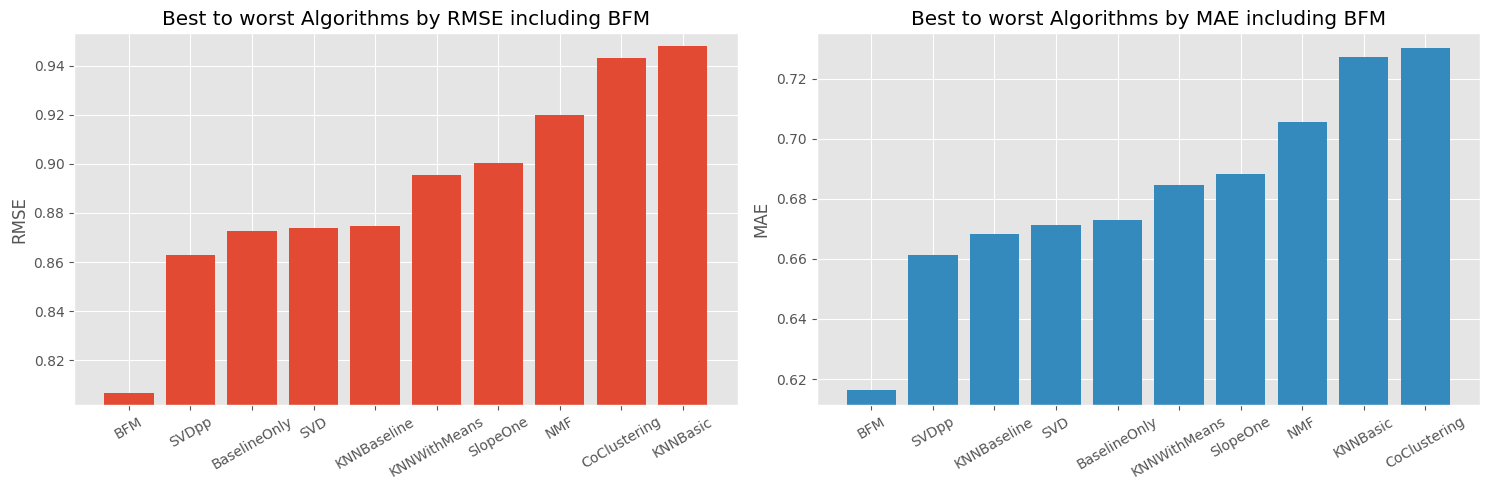

{'BaselineOnly': {'RMSE': 0.8724920183317781, 'MAE': 0.6728003991192218},
 'KNNBasic': {'RMSE': 0.9481740258445395, 'MAE': 0.7272079353654555},
 'KNNWithMeans': {'RMSE': 0.8955956496795819, 'MAE': 0.6844340646070446},
 'KNNBaseline': {'RMSE': 0.8748540091012403, 'MAE': 0.6683146170335565},
 'SVD': {'RMSE': 0.8737709758144181, 'MAE': 0.6711812673921982},
 'SVDpp': {'RMSE': 0.8627264328323765, 'MAE': 0.6611232242151358},
 'NMF': {'RMSE': 0.9200315476119151, 'MAE': 0.705533775296874},
 'SlopeOne': {'RMSE': 0.9003782381054389, 'MAE': 0.6882258082668695},
 'CoClustering': {'RMSE': 0.9430172286942792, 'MAE': 0.7300473908109396},
 'BFM': {'RMSE': 0.8067885988048065, 'MAE': 0.6163814903008937}}

In [25]:
algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
    "BFM",
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)
# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst Algorithms by RMSE including BFM")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst Algorithms by MAE including BFM")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}surpise_BFM_algo_comparison.png", dpi=300)
plt.show()
results

In [ ]:
mlb = MultiLabelBinarizer()
tf.compat.v1.reset_default_graph()

libreco_full = df_rating.merge(df_movie, how="left", on="movieId")
libreco_full = libreco_full.rename(
    columns={"userId": "user", "movieId": "item", "rating": "label"}
)
libreco_full["genres"] = libreco_full["genres"].str.split("|")
genre_encoded = pd.DataFrame(
    mlb.fit_transform(libreco_full["genres"]),
    columns=mlb.classes_,
    index=libreco_full.index,
)
libreco_full = pd.concat([libreco_full, genre_encoded], axis=1).drop(
    columns=["genres", "timestamp"]
)

train_data, eval_data, test_data = random_split(
    libreco_full, multi_ratios=[0.8, 0.1, 0.1], seed=42
)

sparse_col = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "IMAX",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
dense_col = ["release_year"]
user_col = []
item_col = sparse_col + dense_col
train_data, data_info = DatasetFeat.build_trainset(
    train_data,
    user_col=user_col,
    item_col=item_col,
    sparse_col=sparse_col,
    dense_col=dense_col,
)
eval_data = DatasetFeat.build_testset(eval_data)
test_data = DatasetFeat.build_testset(test_data)

# model = NCF(task="rating", data_info=data_info, embed_size=16, n_epochs=10, lr=0.001)
# model.fit(
#     train_data,
#     neg_sampling=False,
#     verbose=2,
#     shuffle=True,
#     eval_data=eval_data,
#     metrics=["rmse", "mae"],
# )

def objective(trial):
    tf.compat.v1.reset_default_graph()
    embed_size = trial.suggest_int("embed_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_int("batch_size", 128, 1024, log=True)
    hidden_units = trial.suggest_categorical(
        "hidden_units", [(64, 32), (128, 64, 32), (256, 128, 64)]
    )
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    reg = trial.suggest_float("reg", 1e-5, 1e-1, log=True)
    sampler = trial.suggest_categorical("sampler", ["random", "unconsumed", "popular"])

    model = NCF(
        task="rating",
        data_info=data_info,
        embed_size=embed_size,
        n_epochs=10,
        lr=lr,
        batch_size=batch_size,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        reg=reg,
        sampler=sampler,
        use_bn=True,
        seed=42,
    )

    model.fit(train_data, neg_sampling=False, eval_data=eval_data, verbose=0)
    result = evaluate(
        model=model,
        data=test_data,
        neg_sampling=False,
        metrics=["rmse"],
    )

    return result["rmse"]

study = optuna.create_study(direction="minimize", study_name="NCF_RMSE_Optimization")
study.optimize(objective, n_trials=20)

print("Best trial:")
best_trial = study.best_trial
print(f"  Value (RMSE): {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2025-03-23 17:53:17,751] A new study created in memory with name: NCF_RMSE_Optimization
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)
/hom

Training start time: 2025-03-23 17:53:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 109.01it/s]
[I 2025-03-23 17:54:03,255] Trial 0 finished with value: 0.879483574111001 and parameters: {'embed_size': 123, 'lr': 0.0001257657003247385, 'batch_size': 176, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.3874662265741923, 'reg': 3.395220543089788e-05, 'sampler': 'unconsumed'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/

Training start time: 2025-03-23 17:54:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 247.15it/s]
[I 2025-03-23 17:54:10,854] Trial 1 finished with value: 0.899876258312898 and parameters: {'embed_size': 93, 'lr': 0.0012831070700393577, 'batch_size': 969, 'hidden_units': (64, 32), 'dropout_rate': 0.2994974495116537, 'reg': 0.0004894722100270627, 'sampler': 'popular'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Deskt

Training start time: 2025-03-23 17:54:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 267.55it/s]
[I 2025-03-23 17:54:17,858] Trial 2 finished with value: 0.9696774680921013 and parameters: {'embed_size': 78, 'lr': 0.06805338264351932, 'batch_size': 946, 'hidden_units': (64, 32), 'dropout_rate': 0.49425644855486406, 'reg': 0.0025007789650074008, 'sampler': 'unconsumed'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/De

Training start time: 2025-03-23 17:54:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 159.58it/s]
[I 2025-03-23 17:54:39,577] Trial 3 finished with value: 0.8920479232203288 and parameters: {'embed_size': 30, 'lr': 0.00022315366908793485, 'batch_size': 160, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.41004370808312374, 'reg': 4.6877264246668775e-05, 'sampler': 'popular'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/

Training start time: 2025-03-23 17:54:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 462.67it/s]
[I 2025-03-23 17:54:47,565] Trial 4 finished with value: 0.9002083053989796 and parameters: {'embed_size': 36, 'lr': 0.0030944614305937674, 'batch_size': 395, 'hidden_units': (64, 32), 'dropout_rate': 0.29897574027312396, 'reg': 0.016721861148994117, 'sampler': 'unconsumed'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/D

Training start time: 2025-03-23 17:54:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 215.29it/s]
[I 2025-03-23 17:55:15,620] Trial 5 finished with value: 0.9233927710713786 and parameters: {'embed_size': 82, 'lr': 0.020280075732510533, 'batch_size': 166, 'hidden_units': (64, 32), 'dropout_rate': 0.25335827947559486, 'reg': 0.000539528170056208, 'sampler': 'popular'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Deskt

Training start time: 2025-03-23 17:55:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 142.79it/s]
[I 2025-03-23 17:55:28,440] Trial 6 finished with value: 0.928033072546075 and parameters: {'embed_size': 122, 'lr': 0.013601640169309467, 'batch_size': 784, 'hidden_units': (128, 64, 32), 'dropout_rate': 0.24227758433284619, 'reg': 0.0044240532246124, 'sampler': 'popular'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/De

Training start time: 2025-03-23 17:55:28


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 213.15it/s]
[I 2025-03-23 17:55:37,689] Trial 7 finished with value: 0.8882268646667557 and parameters: {'embed_size': 85, 'lr': 0.0010665190524405909, 'batch_size': 979, 'hidden_units': (128, 64, 32), 'dropout_rate': 0.11285656171091762, 'reg': 0.017463440882464796, 'sampler': 'random'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/

Training start time: 2025-03-23 17:55:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 113.46it/s]
[I 2025-03-23 17:55:50,052] Trial 8 finished with value: 0.9135641603541976 and parameters: {'embed_size': 111, 'lr': 0.005478940328675064, 'batch_size': 944, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.34554890512472214, 'reg': 9.250911994791643e-05, 'sampler': 'unconsumed'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home

Training start time: 2025-03-23 17:55:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 172.67it/s]
[I 2025-03-23 17:56:06,006] Trial 9 finished with value: 0.8838692265926922 and parameters: {'embed_size': 89, 'lr': 0.0006253003048326498, 'batch_size': 430, 'hidden_units': (128, 64, 32), 'dropout_rate': 0.2472495059274321, 'reg': 0.034065951084561306, 'sampler': 'unconsumed'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/sh

Training start time: 2025-03-23 17:56:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 154.20it/s]
[I 2025-03-23 17:56:27,212] Trial 10 finished with value: 0.883624053288361 and parameters: {'embed_size': 55, 'lr': 0.0001445149816002905, 'batch_size': 253, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.44573296529739637, 'reg': 1.321974253510028e-05, 'sampler': 'random'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/she

Training start time: 2025-03-23 17:56:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 148.33it/s]
[I 2025-03-23 17:56:50,015] Trial 11 finished with value: 0.8853444673425567 and parameters: {'embed_size': 54, 'lr': 0.00010061291789660263, 'batch_size': 246, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.45087509551300253, 'reg': 1.2889696342482948e-05, 'sampler': 'random'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/

Training start time: 2025-03-23 17:56:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 132.73it/s]
[I 2025-03-23 17:57:10,926] Trial 12 finished with value: 0.8850880836938145 and parameters: {'embed_size': 56, 'lr': 0.00028725910182202585, 'batch_size': 257, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.39511712170693736, 'reg': 1.0560081064024722e-05, 'sampler': 'random'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/

Training start time: 2025-03-23 17:57:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 136.29it/s]
[I 2025-03-23 17:57:46,227] Trial 13 finished with value: 0.8845973576850861 and parameters: {'embed_size': 52, 'lr': 0.00010205697808599748, 'batch_size': 129, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.3912352643144957, 'reg': 8.243759820723003e-05, 'sampler': 'random'}. Best is trial 0 with value: 0.879483574111001.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/sh

Training start time: 2025-03-23 17:57:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 112.48it/s]
[I 2025-03-23 17:58:15,131] Trial 14 finished with value: 0.8786542050198971 and parameters: {'embed_size': 102, 'lr': 0.00034706139265638605, 'batch_size': 261, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.47945450248505134, 'reg': 3.203629417307576e-05, 'sampler': 'unconsumed'}. Best is trial 14 with value: 0.8786542050198971.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)


Training start time: 2025-03-23 17:58:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 121.07it/s]
[I 2025-03-23 17:58:51,585] Trial 15 finished with value: 0.8900459700566256 and parameters: {'embed_size': 107, 'lr': 0.0004715427795456101, 'batch_size': 202, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.48908060907190165, 'reg': 0.00019728003592083736, 'sampler': 'unconsumed'}. Best is trial 14 with value: 0.8786542050198971.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)


Training start time: 2025-03-23 17:58:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 109.51it/s]
[I 2025-03-23 17:59:19,895] Trial 16 finished with value: 0.9052671491631056 and parameters: {'embed_size': 123, 'lr': 0.0022180749552757994, 'batch_size': 320, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.363041878918193, 'reg': 3.1647117421243515e-05, 'sampler': 'unconsumed'}. Best is trial 14 with value: 0.8786542050198971.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/h

Training start time: 2025-03-23 17:59:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 125.76it/s]
[I 2025-03-23 17:59:37,284] Trial 17 finished with value: 0.8853725998390819 and parameters: {'embed_size': 104, 'lr': 0.00040021370293671205, 'batch_size': 509, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.43698125696579215, 'reg': 0.00024578254868910836, 'sampler': 'unconsumed'}. Best is trial 14 with value: 0.8786542050198971.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)

Training start time: 2025-03-23 17:59:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 102.16it/s]
[I 2025-03-23 18:00:07,145] Trial 18 finished with value: 0.913729845979801 and parameters: {'embed_size': 127, 'lr': 0.0008702706748363771, 'batch_size': 307, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.16227640869478577, 'reg': 0.0015554585621961384, 'sampler': 'unconsumed'}. Best is trial 14 with value: 0.8786542050198971.
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/shee/Desktop/recsys-movielens/.venv/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/h

Training start time: 2025-03-23 18:00:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 204.37it/s]
[I 2025-03-23 18:00:38,366] Trial 19 finished with value: 0.8829145367368009 and parameters: {'embed_size': 98, 'lr': 0.0002205911156873715, 'batch_size': 202, 'hidden_units': (128, 64, 32), 'dropout_rate': 0.33626370870990335, 'reg': 3.354384446080969e-05, 'sampler': 'unconsumed'}. Best is trial 14 with value: 0.8786542050198971.


Best trial:
  Value (RMSE): 0.8786542050198971
  Params: {'embed_size': 102, 'lr': 0.00034706139265638605, 'batch_size': 261, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.47945450248505134, 'reg': 3.203629417307576e-05, 'sampler': 'unconsumed'}


TypeError: TfBase.fit() missing 1 required positional argument: 'neg_sampling'

/tmp/ipykernel_127856/1243929976.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
/tmp/ipykernel_127856/1243929976.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=["embed_size", "lr"])
[W 2025-03-23 18:49:49,637] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_127856/1243929976.py:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


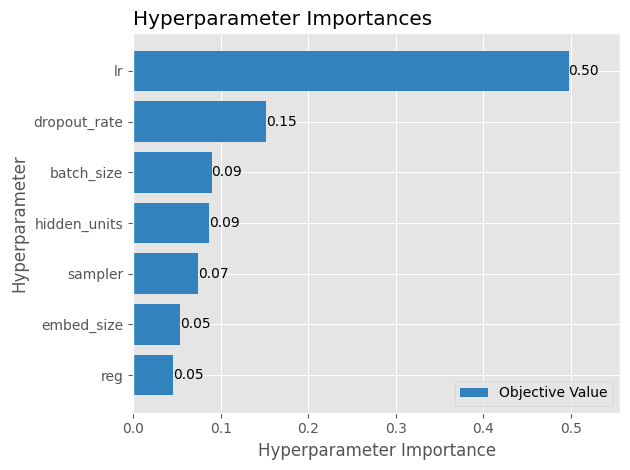

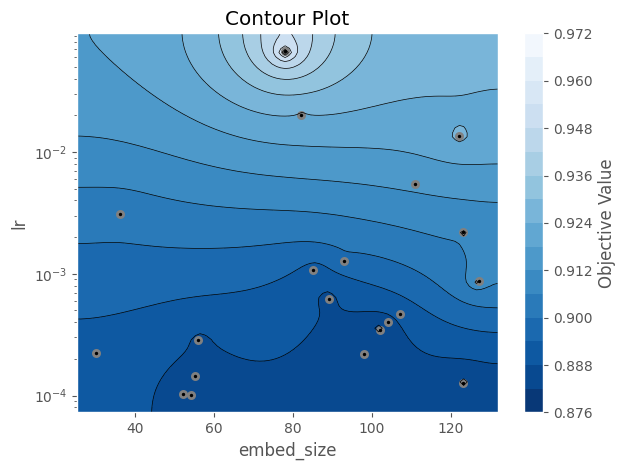

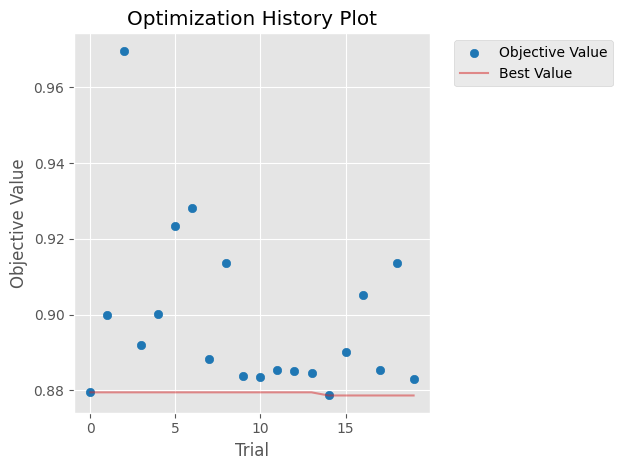

In [144]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.savefig(f"{image_path}ncf_param_importances.png", dpi=300)
optuna.visualization.matplotlib.plot_contour(study, params=["embed_size", "lr"])
plt.tight_layout()
plt.savefig(f"{image_path}ncf_contour.png", dpi=300)
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.savefig(f"{image_path}ncf_optimization_history.png", dpi=300)

In [109]:
tf.compat.v1.reset_default_graph()

final_model = NCF(
    task="rating",
    data_info=data_info,
    embed_size=best_trial.params["embed_size"],
    n_epochs=10,
    lr=best_trial.params["lr"],
    batch_size=best_trial.params["batch_size"],
    hidden_units=best_trial.params["hidden_units"],
    dropout_rate=best_trial.params["dropout_rate"],
    reg=best_trial.params["reg"],
    sampler=best_trial.params["sampler"],
    use_bn=True,
    seed=42,
)

final_model.fit(train_data, neg_sampling=False, eval_data=eval_data, verbose=0)
result = evaluate(
    model=final_model,
    data=test_data,
    neg_sampling=False,
    metrics=["rmse", "mae"],
)
print("Final performance:", result)

Training start time: 2025-03-23 18:09:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 123.70it/s]

Final performance: {'rmse': 0.8786542050198971, 'mae': 0.6684887161484179}
